# Physics 390 - Climate Modelling

The first stage of modelling is to import relevant modules into the notebook. After this, data can be loaded in for each data file provided.


In [96]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from datetime import datetime 
from datetime import timedelta 

In [250]:
# Load satellite data

# Data directories
SATELLITE_DATA_DIR = "Satellite Data/"

# Full satellite data file paths
cloud_fraction_phase_file = SATELLITE_DATA_DIR + '3D_CloudFraction_Phase330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'
cloud_fraction_file = SATELLITE_DATA_DIR + '3D_CloudFraction330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'
ECMWF_ta_plevels_file = SATELLITE_DATA_DIR + 'ECMWF_ta_plevels_2001_2018.nc'
map_low_high_mid_high_file = SATELLITE_DATA_DIR + 'MapLowMidHigh330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'

# Load satellite data into variables with read access
cloud_fraction_phase_data = Dataset(cloud_fraction_phase_file, 'r')
cloud_fraction_data = Dataset(cloud_fraction_file, 'r')
ECMWF_ta_plevels_data = Dataset(ECMWF_ta_plevels_file, 'r')
map_low_high_mid_high_data = Dataset(map_low_high_mid_high_file, 'r')

In [2]:
# Load model data

# Data directories
MODEL_DATA_DIR = "Model Data/"

# Full model data file paths
cl_data_file = MODEL_DATA_DIR + 'clcalipso_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
clt_data_file = MODEL_DATA_DIR + 'cltcalipso_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
cl_ice_data_file = MODEL_DATA_DIR + 'clcalipsoice_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
cl_liq_data_file = MODEL_DATA_DIR + 'clcalipsoliq_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'

# Load model data into variables with readable access
cl_data = Dataset(cl_data_file, 'r')
clt_data = Dataset(clt_data_file, 'r')
cl_ice_data = Dataset(cl_ice_data_file, 'r')
cl_liq_data = Dataset(cl_liq_data_file, 'r')

In [3]:
# Declare some helper methods for easy viewing of data

# Display the names of all data points in the dataset and the number of data points in that set
def print_dataset_overview(dataset):
    print("Variables and Number of Data Points:")
    for key in dataset.variables.keys():
        print("\t", key, ": ", len(dataset.variables[key][:]), " data points")
    print("\n")

# Display the data for the variable name provided
def print_data_points(dataset, variable_name):
    print(variable_name, ":")
    print(dataset.variables[variable_name][:])
    print("\n")

def print_variables(dataset):
    for key in dataset.variables.keys():
        print(key, ": ", dataset.variables[key])
        print("\n")

In [4]:
## Declare some global variables
FIG_WIDTH = 10
FIG_HEIGHT = 5

### Clt Data Structure
From the helper methods above, and after analysing output data for the clt dataset, it appears that the clt data is organised in the following structure:

$cltcalipso[time][lat][lon]=$ fraction cloud cover at given $time$ at the coordinate $(lat, lon)$

In [ ]:
print_dataset_overview(clt_data)
print_data_points(clt_data, "lon")
print_data_points(clt_data, "lat")
print_data_points(clt_data, "cltcalipso")

### First Test Plot: Initial Percentage Cloud Cover
The following plot is playing around with clt data. This is an attempt at plotting the fractional cloud cover at all a range of latitude coordinates, at the first time interval of the dataset.

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()


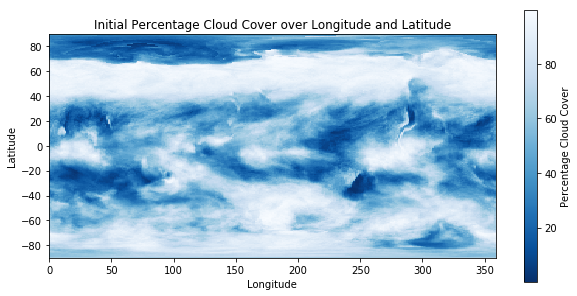

In [59]:
# Plot the percentage cloud cover over longitude and latitude at the first time interval
time_interval = 100

lon_max = max(clt_data.variables['lon'][:])
lon_min = min(clt_data.variables['lon'][:])
lat_max = max(clt_data.variables['lat'][:])
lat_min = min(clt_data.variables['lat'][:])

# Since cloud cover is collected at linearly separated long, lat coords can approximate with this plot
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(clt_data.variables['cltcalipso'][time_interval], interpolation='nearest', 
                       extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Initial Percentage Cloud Cover over Longitude and Latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

### Helper function to extract either summer or winter seasonal data

In [32]:
# Helper function to extract time data for summer and winter periods

# Generate a mask to see which times fall within the given season
def generate_seasonal_time_mask(times, season):
    # Units of time: "days since 0001-01-01 00:00:00"
    reference_datetime = datetime(year=1, month=1, day=1, hour=0, minute=0, second=0)

    times_mask = []

    # Find a subset of cloud cover values for each season
    for i in range(0, len(times)):
        # Find the month corresponding to the current time
        time_delta = timedelta(days=times[i])
        month = (reference_datetime + time_delta).month

        # Time falls between December - February
        if (season == "summer"):
            times_mask.append(True if (month == 12 or month == 1 or month == 2) else False)

        # Time falls between June - August
        if (season == "winter"):
            times_mask.append(True if (month == 6 or month == 7 or month == 8) else False)

    return np.array(times_mask)

<br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> 

# Altitude vs Latitude Cloud Fraction

## Seasonal Cloud Cover: Model Data 

Data points in the $clcalipso$ dataset are of the form $clcalipso[time][alt][lat][lon]$. To plot altitude vs latitude, the dataset must be averaged across all longitudal data points. Please note that most array manipulation operations are done on a single line to conserve program memory from not generating intermediary arrays. I realise this unfortunately reduces readability of the code.

In [208]:
# Global variables used for plotting

# Convert altitude to km
ALT_MIN = np.min(cl_data.variables["alt40"][:])
ALT_MAX = np.max(cl_data.variables["alt40"][:])

LAT_MIN = np.min(cl_data.variables["lat"][:])
LAT_MAX = np.max(cl_data.variables["lat"][:])

In [49]:
# First, extract all data points during the summer then average over all longitudes and all times
mask = generate_seasonal_time_mask(cl_data.variables["time"][:], "summer")
avg_summer_cloud_cover = np.mean(np.mean(cl_data.variables["clcalipso"][mask], axis = 3), axis=0)[::-1]

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until


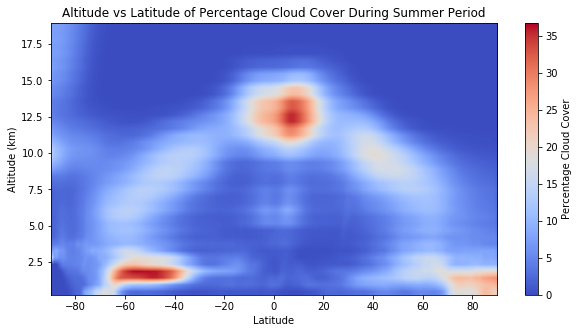

In [194]:
# Plot the altitude vs latitude for summer period
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_summer_cloud_cover, aspect="auto", interpolation='bilinear', 
                       extent=[LAT_MIN, LAT_MAX, ALT_MIN, ALT_MAX])
color_map.set_cmap("coolwarm")
plt.title("Altitude vs Latitude of Percentage Cloud Cover During Summer Period")
plt.xlabel("Latitude")
plt.ylabel("Altitude (km)")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

In [52]:
# First, extract all data points during the winter then average over all longitudes and all times
mask = generate_seasonal_time_mask(cl_data.variables["time"][:], "winter")
avg_winter_cloud_cover = np.mean(np.mean(cl_data.variables["clcalipso"][mask], axis = 3), axis=0)[::-1]

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until


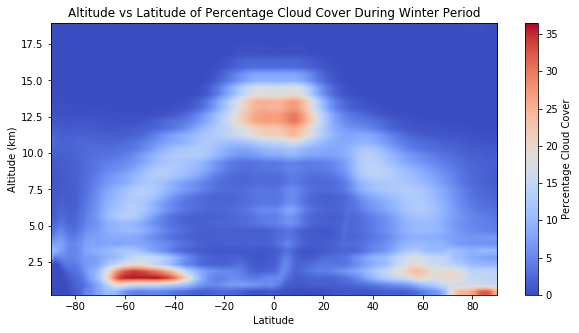

In [193]:
# Plot the altitude vs latitude for winter period
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_winter_cloud_cover, aspect="auto", interpolation='bilinear', 
                       extent=[LAT_MIN, LAT_MAX, ALT_MIN, ALT_MAX])
color_map.set_cmap("coolwarm")
plt.title("Altitude vs Latitude of Percentage Cloud Cover During Winter Period")
plt.xlabel("Latitude")
plt.ylabel("Altitude (km)")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

<br /> <br />
## Seasonal Cloud Cover: Satellite Data

<br /> <br />
## Regional Cloud Cover: Model Data

From analysing the previous plots showing altitude vs latitude cloud cover for different seasons, three regions of interest for further analysis are evident. These regions are those of the highest cloud coverage, and are centered approximately around $(lat, alt)$ coordinates of $(-50, 1), (70, 1), (0, 12)$. The following code generates altitude vs latitude plots zooming in on these regions of interest. Note the following helper method defined to extract regional data from the model. The regions extracted from the data are using the full cl dataset averaged over all time points. These regions have been named as follows: Region 1 is the region centered at $(-50, 1)$, Region 2 is the region centered at $(70, 1)$, Region 3 is the region centered at $(0, 12)$.

In [205]:
# Average over longitude, then average over time to get array of (alt, lat)
avg_cloud_cover = np.mean(np.mean(cl_data.variables["clcalipso"][:], axis=3), axis=0)

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  


In [182]:
# Find the coordinate of the first and last indices of values within the range (min, max)
def find_min_max_indices(values, min_value, max_value):
    i = 0
    while(i < len(values) and values[i] < min_value):
        i += 1
    min_index = i
    
    while(i < len(values) and values[i] < max_value):
        i += 1
    max_index = i
    
    return [min_index, max_index]    

In [240]:
# Helper method to generate regional plots of cl data 
def generate_regional_plot(region_number, alt_max, alt_min, lat_max, lat_min):
    alt_min_index, alt_max_index = find_min_max_indices(cl_data.variables["alt40"][:], alt_min, alt_max)
    lat_min_index, lat_max_index = find_min_max_indices(cl_data.variables["lat"][:], lat_min, lat_max)

    # Extract the cloud cover data from the coordinates within region 1
    region_cloud_cover = avg_cloud_cover[alt_min_index : alt_max_index, lat_min_index : lat_max_index][::-1]

    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    color_map = plt.imshow(region_cloud_cover, aspect="auto", interpolation='bilinear', 
                        extent=[lat_min, lat_max, alt_min, alt_max])
    color_map.set_cmap("coolwarm")

    plt_title = "Altitude vs Latitude of Average Percentage Cloud Cover in Region " + str(region_number)
    plt.title(plt_title)

    plt.xlabel("Latitude")
    plt.ylabel("Altitude")
    cbar = plt.colorbar()
    cbar.set_label("Percentage Cloud Cover")

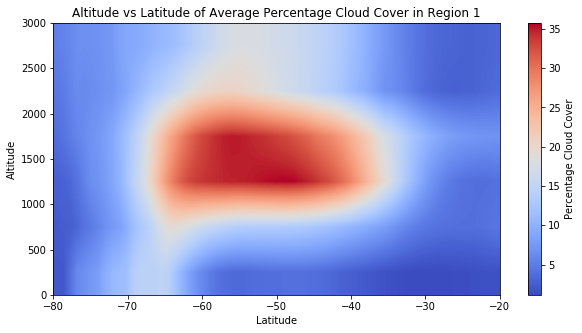

In [247]:
# Plot the average percentage cloud cover over region 1

r1_alt_max = 3000
r1_alt_min = 0
r1_lat_max = -20
r1_lat_min = -80

generate_regional_plot(1, r1_alt_max, r1_alt_min, r1_lat_max, r1_lat_min)

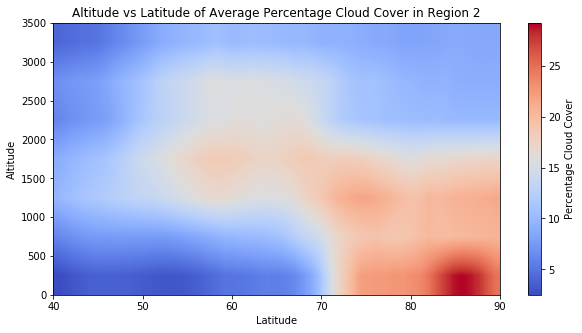

In [248]:
# Plot the average percentage cloud cover over region 2

r2_alt_max = 3500
r2_alt_min = 0
r2_lat_max = 90
r2_lat_min = 40

generate_regional_plot(2, r2_alt_max, r2_alt_min, r2_lat_max, r2_lat_min)

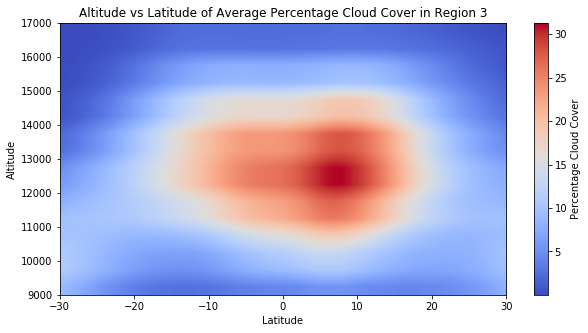

In [245]:
# Plot the average percentage cloud cover over region 3

r3_alt_max = 17000
r3_alt_min = 9000
r3_lat_max = 30
r3_lat_min = -30

generate_regional_plot(3, r3_alt_max, r3_alt_min, r3_lat_max, r3_lat_min)

<br /> <br />
## Regional Cloud Cover: Satellite Data

<br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> 

# Top of the Atmosphere Cloud Fraction 


## Seasonal Cloud Cover: Model Data

In [64]:
# Extract all time and TOA cloud fraction data from dataset
summer_mask = generate_seasonal_time_mask(clt_data.variables["time"][:], "summer")
winter_mask = generate_seasonal_time_mask(clt_data.variables["time"][:], "winter")

# Find subset of TOA cloud cover for each season
avg_cloud_cover_summer = np.mean(clt_data.variables["cltcalipso"][summer_mask], axis=0)[::-1]
avg_cloud_cover_winter = np.mean(clt_data.variables["cltcalipso"][winter_mask], axis=0)[::-1]

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  
C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  import sys


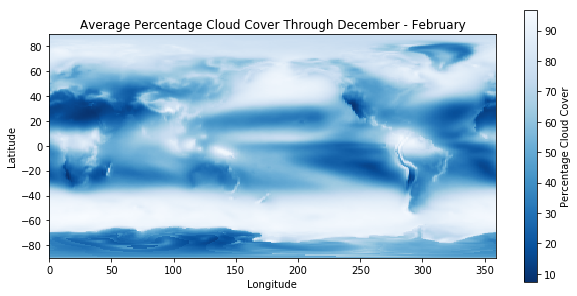

In [68]:
# Plot the average percentage of cloud cover through the winter months
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_cloud_cover_summer, interpolation='nearest', 
                       extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Average Percentage Cloud Cover Through December - February")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

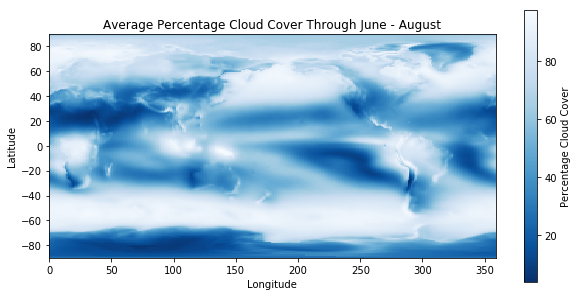

In [67]:
# Plot the average percentage of cloud cover through the summer months
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_cloud_cover_winter, interpolation='nearest', 
                       extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Average Percentage Cloud Cover Through June - August")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

## Seasonal Cloud Cover: Satellite Data
The data provided for top of the atmosphere cloud coverage from satellite readings is already averaged over the time it was collected. This means seasonal cloud coverage times cannot be extracted from the data. The following code instead plots the average TOA cloud coverage over all time. 

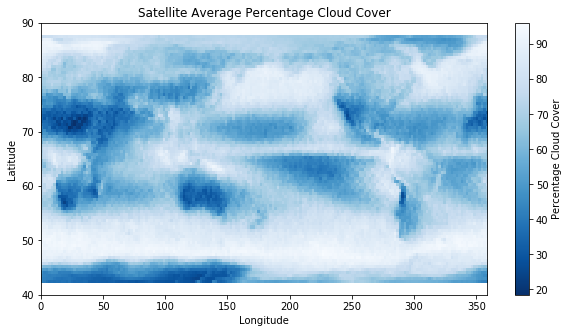

In [303]:
# Convert cloud coverage to a percentage
raw_sat_cloud_coverage = map_low_high_mid_high_data.variables["cltcalipso"][0][::-1] * 100

# Find index position where longitude is closest to 0
lon_0_index = next(x for x, lon in enumerate(map_low_high_mid_high_data.variables["longitude"][:]) if lon >= 0) 

# Align longitude coords with those used in model data
rearranged_indices = np.append(range(lon_0_index, len(raw_sat_cloud_coverage[0])), range(0, lon_0_index))
sat_cloud_coverage = raw_sat_cloud_coverage[:,rearranged_indices]

# Plot the average percentage of cloud cover through the summer months
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(sat_cloud_coverage, interpolation='nearest', 
                       aspect="auto", extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Satellite Average Percentage Cloud Cover")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
cbar.set_label("Percentage Cloud Cover")

<br /> <br />
## Model Biases
It is difficult to find the biases between modelled and satellite data, as longitude and latitude arrays differ between datasets.

<br /> <br /> <br /> 
## Regional Cloud Cover: Model Data
It is difficult to obtain regions of interest in these plots due to the low resolution of the satellite images. The regions of interest have been taken as the regions in the modelled plots which appear to differ the most from summer to winter. 

In [301]:
print(len(avg_cloud_cover_summer[0]))
print(len(sat_cloud_coverage[0]))

288
180
